In [168]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [169]:
# load state data
state_df = pd.read_csv('../data/states.csv')

# drop all entries of Year_Semester including the word "Summer"
state_df = state_df[~state_df['Year_Semester'].str.contains('Summer')]

state_df

,id,Semester_Num,CSCI128,CSCI200,CSCI220,CSCI274,CSCI306,CSCI341,CSCI358,CSCI370,CSCI400,CSCI406,CSCI442,MATH111,MATH112,MATH213,MATH332,Year_Semester
0,3,10094,0,0,1,1,1,1,1,1,1,3,3,0,1,1,1,Fall 2018
1,3,10095,-1,-1,0,0,0,1,1,1,1,2,1,0,1,1,1,Spring 2019
3,3,10099,-1,-1,0,0,-1,0,1,-1,-1,2,0,0,1,1,0,Fall 2019
4,3,10100,-1,-1,0,0,-1,0,0,-1,-2,0,-1,0,1,1,0,Spring 2020
6,3,10104,-1,-1,0,0,-1,0,0,-1,-2,0,-1,0,1,1,0,Fall 2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84834,2186,10120,0,0,1,1,1,1,1,1,1,3,3,0,1,1,1,Spring 2024
84836,6481,10114,0,1,1,1,1,1,1,1,2,3,3,0,1,1,1,Fall 2022
84837,6481,10115,0,1,1,1,1,1,1,1,2,3,3,0,1,1,1,Spring 2023
84839,6481,10119,0,1,1,1,1,1,1,1,2,3,3,0,1,1,1,Fall 2023


In [170]:
print(state_df.columns)

Index(['id', 'Semester_Num', 'CSCI128', 'CSCI200', 'CSCI220', 'CSCI274',
       'CSCI306', 'CSCI341', 'CSCI358', 'CSCI370', 'CSCI400', 'CSCI406',
       'CSCI442', 'MATH111', 'MATH112', 'MATH213', 'MATH332', 'Year_Semester'],
      dtype='object')


In [171]:
classes = ['CSCI128', 'CSCI200', 'CSCI220', 'CSCI274',
       'CSCI306', 'CSCI341', 'CSCI358', 'CSCI370', 'CSCI400', 'CSCI406',
       'CSCI442', 'MATH111', 'MATH112', 'MATH213', 'MATH332']

In [172]:
min_values = [state_df[c].min() for c in classes]
max_values = [state_df[c].max() for c in classes]
global_min = min(min_values)
global_max = max(max_values)

# normalize the data
if (global_max - global_min) < 10: 
    for c in classes:
        state_df[c] = state_df[c] - global_min
else: 
    print("ERROR: signature range is too large")

# set variables to count 
eligible = -1 * global_min

In [173]:
# create column concatenating all columns in classes
state_df['signature'] = state_df[classes].apply(lambda x: ''.join(x.astype(str)), axis=1)

# get list of all signatures
signatures = state_df['signature'].unique()


In [174]:
# create two networks: one showing Fall to Spring transitions, another showing Spring to Fall transitions
G_all = nx.DiGraph()

# add nodes to graph
G_all.add_nodes_from(signatures)

# add 0 weight edges between nodes
for s1 in signatures:
    for s2 in signatures:
        G_all.add_edge(s1, s2, weight=0)
        G_all.add_edge(s2, s1, weight=0)

In [175]:
for id in state_df['id'].unique(): 
    id_df = state_df[state_df['id'] == id]

    # get list in order of signatures
    sigs = id_df['signature'].tolist()

    # add 1 to weight of edge between each pair of signatures
    for i in range(len(sigs) - 1): 
        G_all[sigs[i]][sigs[i+1]]['weight'] += 1
    

In [176]:
# based on graph, create Markov chain matrix
weighted_adj_matrix = nx.to_numpy_array(G_all, weight='weight')

# Normalize the weighted adjacency matrix
row_sums = weighted_adj_matrix.sum(axis=1, keepdims=True)
# Avoid division by zero for rows that sum to zero
row_sums[row_sums == 0] = 1
normalized_adj_matrix = weighted_adj_matrix / row_sums

# Calculating State Changes

In [177]:
def get_state_vector(year_semester):
    spring23_df = state_df[state_df['Year_Semester'] == year_semester]

    # reduce spring23_df to include counts of signatures
    spring23_df = spring23_df.groupby('signature').size().reset_index(name='count')

    # Ensure the DataFrame is ordered to match the Markov matrix
    df_ordered = spring23_df.set_index('signature').reindex(signatures).reset_index()

    # Now, df_ordered['count'] can be directly used as the state vector
    state_vector = df_ordered['count'].fillna(0).to_numpy()

    return state_vector

In [178]:
def count_taken(vector): 
    # create count dictionary
    count_dict = {cl:0 for cl in classes}

    for i in range(len(vector)):
        sig = signatures[i]
        for index,digit in enumerate(str(sig)): 
            if int(digit) < eligible: 
                count_dict[classes[index]] += vector[i]

    return count_dict

In [179]:
def get_enrollment(year_semester): 
    NUM_LIST = ['Cap', 'Act', 'Rem', 'WL Cap','WL Act','WL Rem','XL Cap','XL Act','XL Rem']
    CORE_LIST = ['128', '200', '220', '274', '306', '341', '358', '370', '400', '406', '442']

    # load schedule data
    name = year_semester.split(" ")[0] + year_semester.split(" ")[1][2:]
    schedule_df = pd.read_csv(f'../schedules/{name}.csv')

    # remove 102 entries
    df = schedule_df[schedule_df['Title'] != 'INTRODUCTION TO COMPUTER SCIENCE - LAB']

    # change CrseNum to string
    df['CrseNum'] = df['CrseNum'].astype(str)

    # replace equivalent classes
    df['CrseNum'] = df['CrseNum'].replace('101', '128')
    df['CrseNum'] = df['CrseNum'].replace('261', '200')
    df['CrseNum'] = df['CrseNum'].replace('262', '220')

    # replace equivalent course names
    df['Title'] = df['Title'].replace('INTRODUCTION TO COMPUTER SCIENCE', 'COMPUTER SCIENCE FOR STEM')
    df['Title'] = df['Title'].replace('PROGRAMMING CONCEPTS', 'FOUNDATIONAL PROGRAMMING CONCEPTS & DESIGN')
    df['Title'] = df['Title'].replace('DATA STRUCTURES', 'DATA STRUCTURES AND ALGORITHMS')

    # filter to only CrseNum in CORE_LIST
    df = df[df['CrseNum'].isin(CORE_LIST)]

    # set all columns in NUM_LIST to int
    for col in NUM_LIST:
        df.loc[:,col] = df[col].astype(int)

    # group by class and year
    core_df = df.groupby(['CrseNum','Title']).sum().reset_index()

    return core_df

In [180]:
def find_actual_pass(year_semester): 
    actual_df = pd.read_csv(f'../data/combined.csv')
    actual_df = actual_df[actual_df['Year_Semester'] == year_semester][['Class','Taken']]

    # convert actual_df into dictionary
    actual_dict = actual_df.set_index('Class').to_dict()['Taken']

    if 'CSCI370' not in actual_dict: 
        actual_dict['CSCI370'] = 0

    return actual_dict

In [181]:
semesters_list = ['Spring 2020', 'Fall 2021', 'Spring 2022', 'Fall 2022', 'Spring 2023', 'Fall 2023']

In [182]:
# create storage df
results_df = pd.DataFrame(columns=['year_semester', 'class', 'difference', 'true', 'predicted pass', 'actual enrollment'])

# just cs classes
cs_classes = [cl for cl in classes if cl[:4] == 'CSCI']

# get predictions
for index in range(1, len(semesters_list)):

    # get predicted passes
    state_vector = get_state_vector(semesters_list[index-1])
    predicted_fall23 = state_vector @ normalized_adj_matrix
    predicted_count_dict = count_taken(predicted_fall23)

    # get actual passes
    actual_count_dict = find_actual_pass(semesters_list[index])

    # get previous semester
    prev_count_dict = count_taken(state_vector)

    # get enrollment
    enrollment = get_enrollment(semesters_list[index])

    # find difference prev and true
    true_comparison_dict = {cl: actual_count_dict[cl] for cl in cs_classes}

    # find difference prev and predicted
    predicted_comparison_dict = {cl: predicted_count_dict[cl] - prev_count_dict[cl] for cl in cs_classes}

    # find error between true and predicted
    error_dict = {cl: actual_count_dict[cl] - predicted_comparison_dict[cl] for cl in cs_classes}

    # find difference true and predicted
    print(f"PREDICTIONS FOR {semesters_list[index].upper()}")
    for cl in cs_classes: 
        enroll_value = enrollment[enrollment['CrseNum'] == cl[4:]]['Act'].values[0]

        # add results to results_df
        results_df = pd.concat([results_df, pd.DataFrame([[semesters_list[index], cl, error_dict[cl], true_comparison_dict[cl], predicted_comparison_dict[cl], enroll_value]], 
                                                         columns=['year_semester', 'class', 'difference', 'true', 'predicted pass', 'actual enrollment'])])


/var/folders/kj/d1xg4wx91kd1nwc9s2xdpz_r0000gn/T/ipykernel_42696/1959220545.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CrseNum'] = df['CrseNum'].astype(str)
/var/folders/kj/d1xg4wx91kd1nwc9s2xdpz_r0000gn/T/ipykernel_42696/1959220545.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CrseNum'] = df['CrseNum'].replace('101', '128')
/var/folders/kj/d1xg4wx91kd1nwc9s2xdpz_r0000gn/T/ipykernel_42696/1959220545.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

PREDICTIONS FOR FALL 2021
PREDICTIONS FOR SPRING 2022
PREDICTIONS FOR FALL 2022
PREDICTIONS FOR SPRING 2023
PREDICTIONS FOR FALL 2023


/var/folders/kj/d1xg4wx91kd1nwc9s2xdpz_r0000gn/T/ipykernel_42696/1959220545.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CrseNum'] = df['CrseNum'].astype(str)
/var/folders/kj/d1xg4wx91kd1nwc9s2xdpz_r0000gn/T/ipykernel_42696/1959220545.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CrseNum'] = df['CrseNum'].replace('101', '128')
/var/folders/kj/d1xg4wx91kd1nwc9s2xdpz_r0000gn/T/ipykernel_42696/1959220545.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [183]:
# calculate pass rate
results_df['pass rate'] = (results_df['true'] + 0.00000001 )/ (results_df['actual enrollment'] + 0.00000001)

In [184]:
# average error and pass rates across all semesters
grouped_df = results_df.drop(columns=['year_semester']).groupby('class').mean().reset_index()

In [185]:
# find predicted enrollment based on historical pass rate
results_df['predicted enrollment'] = results_df['predicted pass'] / results_df['pass rate']
results_df['error'] = (results_df['predicted enrollment'] - results_df['actual enrollment']) / (results_df['actual enrollment'] + 0.00000001)
display(results_df)

,year_semester,class,difference,true,predicted pass,actual enrollment,pass rate,predicted enrollment,error
0,Fall 2021,CSCI128,164.257938,408,243.742062,474,0.860759,283.170925,-0.402593
0,Fall 2021,CSCI200,-129.530822,173,302.530822,209,0.827751,365.485212,0.748733
0,Fall 2021,CSCI220,151.783379,254,102.216621,566,0.448763,227.774046,-0.597572
0,Fall 2021,CSCI274,142.152100,223,80.847900,250,0.892,90.63666,-0.637453
0,Fall 2021,CSCI306,48.564371,150,101.435629,158,0.949367,106.845529,-0.323762
0,Fall 2021,CSCI341,65.017287,157,91.982713,183,0.857923,107.215519,-0.414123
0,Fall 2021,CSCI358,61.454966,138,76.545034,157,0.878981,87.083844,-0.445326
0,Fall 2021,CSCI370,10.159943,78,67.840057,83,0.939759,72.188778,-0.130256
0,Fall 2021,CSCI400,32.855647,123,90.144353,132,0.931818,96.740281,-0.267119
0,Fall 2021,CSCI406,62.358391,114,51.641609,128,0.890625,57.983561,-0.547003


In [186]:
grouped_df = results_df.drop(columns=['year_semester']).groupby('class').mean().reset_index()
display(grouped_df)

,class,difference,true,predicted pass,actual enrollment,pass rate,predicted enrollment,error
0,CSCI128,26.852684,536.8,509.947316,594.8,0.898864,564.836179,-0.037114
1,CSCI200,-31.101214,218.0,249.101214,271.2,0.801227,309.880357,0.187918
2,CSCI220,-33.490428,184.2,217.690428,297.8,0.698192,326.258874,0.287003
3,CSCI274,-8.688768,169.6,178.288768,186.8,0.906622,195.838721,0.131441
4,CSCI306,2.333536,159.4,157.066464,165.2,0.964025,162.924225,-0.000684
5,CSCI341,-13.057774,144.4,157.457774,154.6,0.942406,172.906619,0.138575
6,CSCI358,41.399036,161.2,119.800964,177.0,0.909794,131.520185,-0.266461
7,CSCI370,-50.204402,61.0,111.204402,62.4,0.984423,112.551016,4413235316.316026
8,CSCI400,13.341982,130.0,116.658018,138.4,0.935254,125.439813,-0.053838
9,CSCI406,50.466514,145.2,94.733486,162.4,0.894203,105.712368,-0.356742


In [187]:
# print average difference between true and predicted
for cl in cs_classes:
    print(f"{cl}")
    print(f"\tAVG. DIFF: {results_df[results_df['class'] == cl]['difference'].mean()}")

    # find percent error compared to true
    print(f"\tAVG. ERROR: {results_df['error'].mean()}%")

    # calculate historical pass rate for class
    print(f"\tAVG. PASS: {results_df[results_df['class'] == cl]['pass rate'].mean()}")

    print()

CSCI128
	AVG. DIFF: 26.852684009995208
	AVG. ERROR: 401203210.55683506%
	AVG. PASS: 0.8988642548003153

CSCI200
	AVG. DIFF: -31.101213921385078
	AVG. ERROR: 401203210.55683506%
	AVG. PASS: 0.8012272619133514

CSCI220
	AVG. DIFF: -33.49042815703076
	AVG. ERROR: 401203210.55683506%
	AVG. PASS: 0.6981917697045652

CSCI274
	AVG. DIFF: -8.688767893642671
	AVG. ERROR: 401203210.55683506%
	AVG. PASS: 0.9066222165453928

CSCI306
	AVG. DIFF: 2.333536066867498
	AVG. ERROR: 401203210.55683506%
	AVG. PASS: 0.9640251475311216

CSCI341
	AVG. DIFF: -13.057774207181637
	AVG. ERROR: 401203210.55683506%
	AVG. PASS: 0.9424055677321987

CSCI358
	AVG. DIFF: 41.39903554844251
	AVG. ERROR: 401203210.55683506%
	AVG. PASS: 0.9097938337371543

CSCI370
	AVG. DIFF: -50.20440188430676
	AVG. ERROR: 401203210.55683506%
	AVG. PASS: 0.9844227580705646

CSCI400
	AVG. DIFF: 13.34198171006201
	AVG. ERROR: 401203210.55683506%
	AVG. PASS: 0.9352536658781048

CSCI406
	AVG. DIFF: 50.466514030048494
	AVG. ERROR: 401203210.556

In [190]:
display(results_df)

,year_semester,class,difference,true,predicted pass,actual enrollment,pass rate,predicted enrollment,error
0,Fall 2021,CSCI128,164.257938,408,243.742062,474,0.860759,283.170925,-0.402593
0,Fall 2021,CSCI200,-129.530822,173,302.530822,209,0.827751,365.485212,0.748733
0,Fall 2021,CSCI220,151.783379,254,102.216621,566,0.448763,227.774046,-0.597572
0,Fall 2021,CSCI274,142.152100,223,80.847900,250,0.892,90.63666,-0.637453
0,Fall 2021,CSCI306,48.564371,150,101.435629,158,0.949367,106.845529,-0.323762
0,Fall 2021,CSCI341,65.017287,157,91.982713,183,0.857923,107.215519,-0.414123
0,Fall 2021,CSCI358,61.454966,138,76.545034,157,0.878981,87.083844,-0.445326
0,Fall 2021,CSCI370,10.159943,78,67.840057,83,0.939759,72.188778,-0.130256
0,Fall 2021,CSCI400,32.855647,123,90.144353,132,0.931818,96.740281,-0.267119
0,Fall 2021,CSCI406,62.358391,114,51.641609,128,0.890625,57.983561,-0.547003


# Spring 24 Enrollment

In [191]:
print(results_df.columns)

Index(['year_semester', 'class', 'difference', 'true', 'predicted pass',
       'actual enrollment', 'pass rate', 'predicted enrollment', 'error'],
      dtype='object')


In [192]:
state_vector = get_state_vector('Fall 2023')
predicted_spring2024 = state_vector @ normalized_adj_matrix
predicted_count_dict = count_taken(predicted_spring2024)

# get Fall 2023 actual passes
prev_count_dict = count_taken(state_vector)

# get enrollment
enrollment = get_enrollment('Spring 2024')

# find difference prev and predicted
predicted_comparison_dict = {cl: predicted_count_dict[cl] - prev_count_dict[cl] for cl in cs_classes}

# find difference between enrollment and predicted
print(f"PREDICTIONS FOR SPRING 2024")
for cl in cs_classes: 
    enroll_value = enrollment[enrollment['CrseNum'] == cl[4:]]['Act'].values[0]

    predicted_enrollment = predicted_comparison_dict[cl] / grouped_df[grouped_df['class'] == cl]['pass rate'].values[0]

    print(f"{cl}")
    print(f"\tPREDICTED ENROLL: {predicted_enrollment}")
    print(f"\tENROLLMENT: {enroll_value}")
    print(f"\tCAPACITY: {enrollment[enrollment['CrseNum'] == cl[4:]]['Cap'].values[0]}")
    print(f"\tERROR: {(predicted_enrollment - enroll_value) / enroll_value}")
    print()

    # add to results_df
    results_df = pd.concat([results_df, pd.DataFrame([['Spring 2024', cl, 0, 0, predicted_comparison_dict[cl], enroll_value, 0, predicted_enrollment, (predicted_enrollment - enroll_value) / enroll_value]], 
                                                     columns=['year_semester', 'class', 'difference', 'true', 'predicted pass',
                                                                'actual enrollment', 'pass rate', 'predicted enrollment', 'error'])])

PREDICTIONS FOR SPRING 2024
CSCI128
	PREDICTED ENROLL: 552.4959257349975
	ENROLLMENT: 572
	CAPACITY: 610
	ERROR: -0.03409803193182253

CSCI200
	PREDICTED ENROLL: 438.9932465147515
	ENROLLMENT: 302
	CAPACITY: 300
	ERROR: 0.4536200215720248

CSCI220
	PREDICTED ENROLL: 488.92802705727445
	ENROLLMENT: 200
	CAPACITY: 220
	ERROR: 1.4446401352863723

CSCI274
	PREDICTED ENROLL: 314.02830031419336
	ENROLLMENT: 106
	CAPACITY: 150
	ERROR: 1.96253113503956

CSCI306
	PREDICTED ENROLL: 202.77989401998357
	ENROLLMENT: 168
	CAPACITY: 180
	ERROR: 0.2070231786903784

CSCI341
	PREDICTED ENROLL: 224.98688962874618
	ENROLLMENT: 170
	CAPACITY: 170
	ERROR: 0.3234522919338011

CSCI358
	PREDICTED ENROLL: 165.4431257571118
	ENROLLMENT: 194
	CAPACITY: 210
	ERROR: -0.1472003826953

CSCI370
	PREDICTED ENROLL: 138.8769560928583
	ENROLLMENT: 0
	CAPACITY: 0
	ERROR: inf

CSCI400
	PREDICTED ENROLL: 130.38556277708403
	ENROLLMENT: 111
	CAPACITY: 140
	ERROR: 0.17464470970345974

CSCI406
	PREDICTED ENROLL: 138.47469934921

/var/folders/kj/d1xg4wx91kd1nwc9s2xdpz_r0000gn/T/ipykernel_42696/253753689.py:25: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"\tERROR: {(predicted_enrollment - enroll_value) / enroll_value}")
/var/folders/kj/d1xg4wx91kd1nwc9s2xdpz_r0000gn/T/ipykernel_42696/253753689.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  results_df = pd.concat([results_df, pd.DataFrame([['Spring 2024', cl, 0, 0, predicted_comparison_dict[cl], enroll_value, 0, predicted_enrollment, (predicted_enrollment - enroll_value) / enroll_value]],


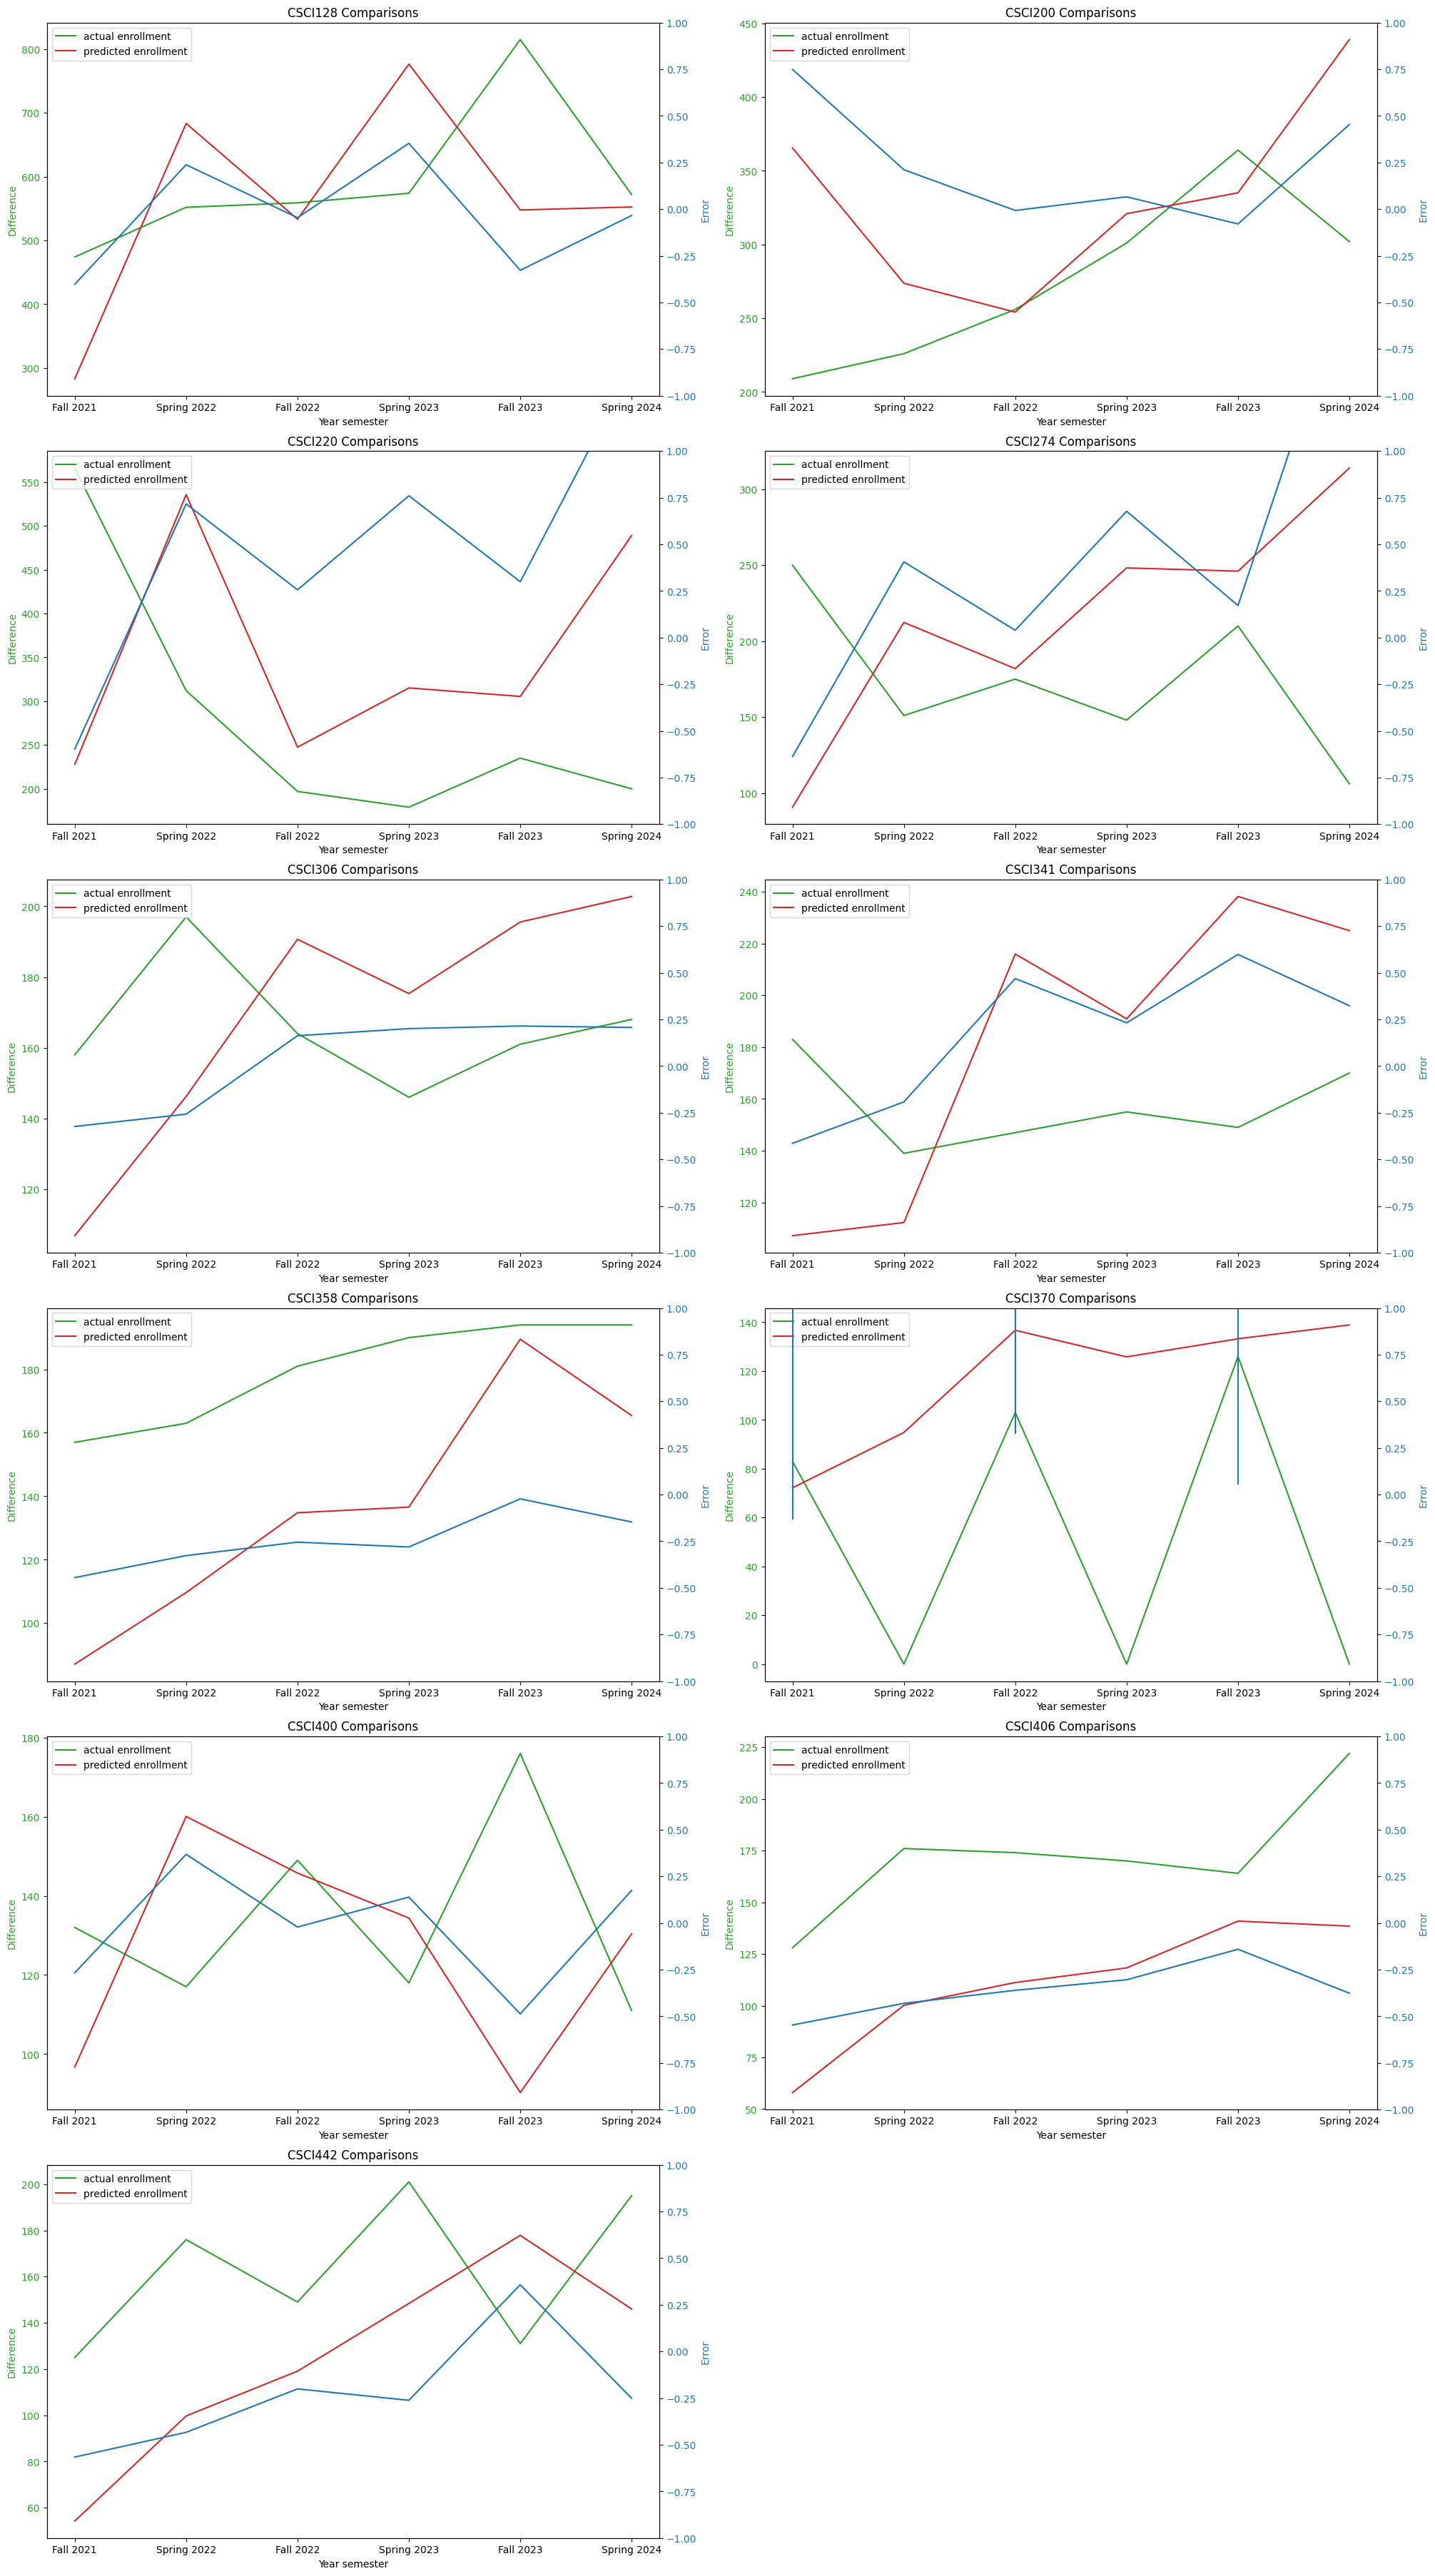

In [193]:
# Calculate the number of rows and columns for the subplot grid
num_classes = len(cs_classes)
num_rows = int(np.ceil(num_classes / 2))  # Adjust the divisor to change the number of columns

# Create a figure with subplots
fig, axs = plt.subplots(num_rows, 2, figsize=(20, 6 * num_rows), constrained_layout=True)
axs = axs.flatten()  # Flatten the array for easy iteration

for i, cl in enumerate(cs_classes):
    plot_df = results_df[results_df['class'] == cl]
    
    # Select the subplot for the current class
    ax1 = axs[i]

    # Plotting on the primary y-axis
    color = 'tab:green'
    ax1.set_xlabel('Year semester')
    ax1.set_ylabel('Difference', color=color)
    ax1.plot(plot_df['year_semester'], plot_df['actual enrollment'], color=color, label='actual enrollment')
    ax1.plot(plot_df['year_semester'], plot_df['predicted enrollment'], color='tab:red', label='predicted enrollment')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')

    # Creating a secondary y-axis for the current subplot
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Error', color=color)
    ax2.plot(plot_df['year_semester'], plot_df['error'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim([-1, 1])

    # Set the title for the current subplot
    ax1.set_title(f"{cl} Comparisons")

# Hide unused subplots if the number of classes is odd
if num_classes % 2 != 0:
    axs[-1].axis('off')

plt.show()

# Spring 2024 Prediction

PREDICTIONS FOR SPRING 2024
CSCI128
	PREDICTED ENROLL: 552.4959257349975
	ENROLLMENT: 572
	CAPACITY: 610
	ERROR: -0.03409803193182253

CSCI200
	PREDICTED ENROLL: 438.9932465147515
	ENROLLMENT: 302
	CAPACITY: 300
	ERROR: 0.4536200215720248

CSCI220
	PREDICTED ENROLL: 488.92802705727445
	ENROLLMENT: 200
	CAPACITY: 220
	ERROR: 1.4446401352863723

CSCI274
	PREDICTED ENROLL: 314.02830031419336
	ENROLLMENT: 106
	CAPACITY: 150
	ERROR: 1.96253113503956

CSCI306
	PREDICTED ENROLL: 202.77989401998357
	ENROLLMENT: 168
	CAPACITY: 180
	ERROR: 0.2070231786903784

CSCI341
	PREDICTED ENROLL: 224.98688962874618
	ENROLLMENT: 170
	CAPACITY: 170
	ERROR: 0.3234522919338011

CSCI358
	PREDICTED ENROLL: 165.4431257571118
	ENROLLMENT: 194
	CAPACITY: 210
	ERROR: -0.1472003826953

CSCI370
	PREDICTED ENROLL: 138.8769560928583
	ENROLLMENT: 0
	CAPACITY: 0
	ERROR: inf

CSCI400
	PREDICTED ENROLL: 130.38556277708403
	ENROLLMENT: 111
	CAPACITY: 140
	ERROR: 0.17464470970345974

CSCI406
	PREDICTED ENROLL: 138.47469934921

/var/folders/kj/d1xg4wx91kd1nwc9s2xdpz_r0000gn/T/ipykernel_42696/2148592507.py:25: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"\tERROR: {(predicted_enrollment - enroll_value) / enroll_value}")


In [ ]:
# go back and attempt to alter number of states based on previous error
historical_error_dict = {cl: results_df[results_df['class'] == cl]['error'].mean() for cl in cs_classes}

